In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

#### Import data & packages for cleaning

In [3]:
import pandas as pd
import string
import regex as re
from nltk.stem.lancaster import LancasterStemmer
df = pd.read_csv("Cleaned_Data.csv")

#### Use Regex & Python string library to remove numbers, special characters, capitalizations from tweets. 

In [157]:
df.columns

Index(['Date_Time', 'Username', 'Tweet'], dtype='object')

In [4]:
df["Tweet"]=df.Tweet.apply(lambda x: re.sub("[^a-zA-Z:,@#'\s]+","",x))
df["Tweet"]=df["Tweet"].apply(lambda x: x.lower())
df["Tweet"] = df.Tweet.map(lambda x: re.sub('[%s]' % re.escape(string.punctuation),' ',x))
stemmer = LancasterStemmer()
df["Tweet"] = df["Tweet"].apply(lambda x: stemmer.stem(x))

#### First of 4 groups (400K each)

In [5]:
tweets_400K = df["Tweet"][:400_001]
tweets_400K_list = list(tweets_400K)

In [6]:
tweets_400K.head()

0    is upset that he can t update his facebook by ...
1     kenichan i dived many times for the ball mana...
2      my whole body feels itchy and like its on fire 
3     nationwideclass no  it s not behaving at all ...
4                         kwesidei not the whole crew 
Name: Tweet, dtype: object

#### Reduce tweets to nouns for topic modelling

In [7]:
import nltk
nltk.download('brown')
import textblob
from textblob import TextBlob

[nltk_data] Downloading package brown to
[nltk_data]     /Users/francescaepiccorelli/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [8]:
acceptable_types = ["NN","NNS","NNP","NNPS"]

In [9]:
def nouns_only(string_list):
    new_tweet_list = []
    for string in string_list:
        new_string_list = []
        blob_list = TextBlob(string)
        for blob in blob_list.tags:
            if blob[1] in acceptable_types:
                new_string_list.append(blob[0])
        new_string = " ".join(new_string_list)
        new_tweet_list.append(new_string)
    return new_tweet_list

In [10]:
please_work = nouns_only(["Victoria is going to Washington, DC to see George Washington's monument.",
             "Jane fell down the well and hit water"])
print(please_work)

['Victoria Washington DC George Washington monument', 'Jane well hit water']


In [11]:
nouns_400K_list = nouns_only(tweets_400K_list)

In [12]:
nouns_400K_list[:5]

['facebook result school today',
 'kenichan i times ball rest bounds',
 'body feels fire',
 'nationwideclass m i',
 'kwesidei whole crew']

#### Create stop_word list to remove unnecessary nouns
##### Repetitive nouns or words mistaken as nouns still pose a problem

In [13]:
from sklearn.feature_extraction import text

In [14]:
addl_stop_words = ["ah",
"ahh",
"ahhh",
"ahhhh",
"alot",
"amp",
"aren",
"arent",
"argh",
"ass",
"aw",
"aww",
"awww",
"awwww",
"babe",
"baby",
"bad",
"bc",
"big",
"bit",
"bitch",
"blah",
"boo",
"bout",
"boy",
"boys",
"btw",
"bye",
"cnt",
"cos",
"couldn",
"coz",
"cuz",
"da",
"dam",
"day",
"days",
"dear",
"decent",
"def",
"did",
"didn",
"didnt",
"dnt",
"doesn",
"doesn’t",
"doesnt",
"doin",
"don",
"dont",
"dude",
"feeling",
"fml",
"friday",
"fuck",
"getting",
"girl",
"girls",
"god",
"goin",
"gon",
"gonna",
"good",
"goodbye",
"goodnight",
"goood",
"gosh",
"great",
"gt",
"guess",
"gunna",
"guy",
"guys",
"ha",
"haha",
"hahaha",
"hahahaha",
"hard",
"hav",
"haven",
"havin",
"hell",
"hey",
"hi",
"hope",
"hour",
"hours",
"hrs",
"http",
"huge",
"idk",
"im",
"isn",
"isnt",
"jk",
"jus",
"just",
"kno",
"lady",
"left",
"lil",
"link",
"little",
"ll",
"lmao",
"lol",
"long",
"lot",
"lots",
"love",
"lt",
"luv",
"ma",
"making",
"man",
"monday",
"morning",
"moro",
"morrow",
"mr",
"na",
"nd",
"new",
"nice",
"night",
"nights",
"nite",
"noes",
"nope",
"oh",
"ohh",
"ok",
"okay",
"omg",
"omgosh",
"ones",
"ouch",
"ouch",
"ouch",
"ow",
"ow",
"ow",
"past",
"people",
"plz",
"pm",
"poor",
"poor",
"rd",
"ready",
"ready",
"real",
"real",
"right",
"rip",
"rip",
"saturday",
"shit",
"sleepy",
"sleepy",
"so",
"soo",
"sooo",
"soooo",
"sooooo",
"soooooo",
"sorry",
"st",
"st",
"stay",
"stuff",
"stupid",
"sucks",
"sunday",
"super",
"ta",
"terrible",
"th",
"th",
"thanks",
"thats",
"thing",
"things",
"tho",
"thursday",
"til",
"till",
"time",
"times",
"today",
"tommorow",
"tomorrow",
"tomorrow",
"tomorrow",
"tomorrow",
"tonight",
"tuesday",
"ugh",
"ughh",
"uh",
"ur",
"ve",
"vs",
"vs",
"wait",
"wan",
"wanna",
"want",
"wasn",
"way",
"wednesday",
"wee",
"week",
"weekend",
"weeks",
"wish",
"wit",
"wit",
"wont",
"wouldn",
"wouldnt",
"wow",
"xd",
"xoxo",
"xoxo",
"xx",
"ya",
"ya",
"yay",
"yea",
"yeah",
"year",
"years",
"yes",
"yesterday",
"yo",
"yr"]

In [15]:
stop_word_list = text.ENGLISH_STOP_WORDS.union(addl_stop_words)

#### Function for Topics with Different Parameters

In [16]:
import numpy as np

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

In [18]:
def topic_printer(cv,topic_count,solver_type,tweet_list):
    X = cv.fit_transform(tweet_list)
    df = pd.DataFrame(X.toarray(),columns=cv.get_feature_names())
    words = np.array(cv.get_feature_names())
    nmf = NMF(n_components=topic_count,solver=solver_type)
    W = nmf.fit_transform(X)
    H = nmf.components_
    for i, topic in enumerate(H):
        print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-10:]]])))
    return

#### Model A: Words must appear in .1% of all 400_000 documents

In [19]:
cv_A = CountVectorizer(stop_words = stop_word_list, min_df = .001)
topic_count_A = 20
solver = 'mu'

In [20]:
topic_printer(cv_A,topic_count_A,solver,nouns_400K_list)

/Users/francescaepiccorelli/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic 1: coffee,cause,holiday,lunch,office,shift,computer,college,job,work
Topic 2: beach,party,bus,sad,food,internet,family,mom,sick,home
Topic 3: bus,end,test,finals,exam,exams,kids,class,homework,school
Topic 4: tweet,updates,world,tweets,account,followers,facebook,pic,picture,twitter
Topic 5: battery,computer,tweet,mom,text,tweets,iphone,number,internet,phone
Topic 6: cold,head,flu,pain,dog,tv,feel,room,sick,bed
Topic 7: money,job,world,moment,mom,friend,rest,story,hate,life
Topic 8: kids,dad,parents,dog,room,friend,party,mom,food,house
Topic 9: walk,park,plans,cause,sunshine,beach,hair,hate,looks,rain
Topic 10: homework,trip,head,class,money,room,family,sounds,party,fun
Topic 11: head,drive,money,shop,start,dad,door,friend,mom,car
Topic 12: cause,sad,flight,mom,france,air,friend,party,family,friends
Topic 13: exam,cause,pain,tv,hair,cold,room,computer,money,damn
Topic 14: sunshine,party,holiday,shame,crap,beach,office,hate,cold,weather
Topic 15: room,lunch,garden,exam,friend,head,

#### Same code but with TextBlob Noun Phases

In [21]:
topic_printer(cv_A,topic_count_A,solver,phrases_400K_list)

NameError: name 'phrases_400K_list' is not defined

#### Model B: no min_df

In [22]:
cv_B = CountVectorizer(stop_words = stop_word_list)
topic_count_B = 20
solver = 'mu'

In [23]:
topic_printer(cv_B,topic_count_B,solver,nouns_400K_list)

Topic 1: cause,holiday,stuck,lunch,office,shift,computer,college,job,work
Topic 2: beach,bus,party,sad,food,internet,family,mom,sick,home
Topic 3: test,holidays,finals,starts,exam,exams,kids,class,homework,school
Topic 4: updates,world,background,tweets,account,followers,facebook,pic,picture,twitter
Topic 5: mom,tweet,text,tweets,iphone,number,charger,internet,cell,phone
Topic 6: cold,flu,dog,pain,tv,feel,head,room,sick,bed
Topic 7: family,world,job,moment,mom,rest,friend,story,hate,life
Topic 8: kids,dad,parents,dog,room,friend,party,mom,food,house
Topic 9: cause,thunder,sunshine,forecast,beach,wind,hair,hate,looks,rain
Topic 10: homework,trip,class,money,head,room,family,sounds,party,fun
Topic 11: head,shop,start,money,dad,door,friend,accident,mom,car
Topic 12: cause,sad,flight,mom,france,air,party,friend,family,friends
Topic 13: exam,cause,pain,cold,tv,hair,room,computer,money,damn
Topic 14: forecast,rainy,holiday,shame,crap,beach,office,hate,cold,weather
Topic 15: room,garden,exam,

#### Model C: max_df. can't appear in more than 20% of documents

In [24]:
cv_C = CountVectorizer(stop_words = stop_word_list,max_df=.20)
topic_count_C = 20
solver = 'mu'

In [25]:
topic_printer(cv_C,topic_count_C,solver,nouns_400K_list)

Topic 1: cause,holiday,stuck,lunch,office,shift,computer,college,job,work
Topic 2: beach,bus,party,sad,food,internet,family,mom,sick,home
Topic 3: test,holidays,finals,starts,exam,exams,kids,class,homework,school
Topic 4: updates,world,background,tweets,account,followers,facebook,pic,picture,twitter
Topic 5: tweet,mom,text,tweets,iphone,number,charger,internet,cell,phone
Topic 6: head,cold,flu,pain,dog,tv,feel,room,sick,bed
Topic 7: money,job,world,moment,mom,rest,friend,story,hate,life
Topic 8: kids,dad,parents,dog,room,friend,party,mom,food,house
Topic 9: cause,thunder,sunshine,forecast,beach,wind,hair,hate,looks,rain
Topic 10: homework,trip,head,class,money,room,family,sounds,party,fun
Topic 11: head,shop,start,money,dad,door,friend,accident,mom,car
Topic 12: cause,sad,mom,flight,france,air,party,friend,family,friends
Topic 13: cause,exam,pain,cold,tv,hair,room,computer,money,damn
Topic 14: forecast,rainy,holiday,shame,crap,beach,office,hate,cold,weather
Topic 15: room,garden,exam,h

#### Model D: max_df. can't appear in more than 10% of documents

In [26]:
cv_D = CountVectorizer(stop_words = stop_word_list,max_df=.10)
topic_count_D= 20
solver = 'mu'

In [27]:
topic_printer(cv_D,topic_count_D,solver,nouns_400K_list)

Topic 1: cause,holiday,stuck,lunch,office,shift,computer,college,job,work
Topic 2: beach,party,bus,sad,food,internet,family,mom,sick,home
Topic 3: test,holidays,finals,starts,exam,exams,kids,class,homework,school
Topic 4: updates,world,background,tweets,account,followers,facebook,pic,picture,twitter
Topic 5: tweet,mom,text,tweets,iphone,number,charger,internet,cell,phone
Topic 6: head,cold,flu,dog,pain,tv,feel,room,sick,bed
Topic 7: family,world,job,moment,mom,friend,rest,story,hate,life
Topic 8: kids,dad,parents,dog,room,friend,party,mom,food,house
Topic 9: cause,thunder,sunshine,forecast,beach,wind,hair,hate,looks,rain
Topic 10: homework,head,trip,class,money,room,family,sounds,party,fun
Topic 11: head,shop,start,money,dad,door,friend,accident,mom,car
Topic 12: cause,sad,mom,flight,france,air,party,friend,family,friends
Topic 13: cause,exam,pain,cold,tv,hair,room,computer,money,damn
Topic 14: forecast,rainy,holiday,shame,crap,beach,office,hate,cold,weather
Topic 15: room,hair,garden,

### TextBlob Noun Phrases

In [28]:
def blob_nouns_only(string_list):
    new_tweet_list = []
    for string in string_list:
        new_string_list = []
        blob = TextBlob(string)
        noun_list = blob.noun_phrases
        for noun in noun_list:
            new_tweet_list.append(noun)
    return new_tweet_list

In [29]:
#### Model E: Blob Phrase Analysis

In [30]:
phrases_400K_list = blob_nouns_only(tweets_400K_list)

In [31]:
cv_E = CountVectorizer(stop_words = stop_word_list)
topic_count_E= 20
solver = 'mu'

In [32]:
topic_printer(cv_E,topic_count_E,solver,phrases_400K_list)

Topic 1: laptop,paper,schedule,course,computer,finish,yard,college,uni,work
Topic 2: sigh,followers,dire,friends,life,desperate,food,coffee,money,need
Topic 3: lauren,movie,pretty,life,song,story,panda,news,face,sad
Topic 4: deprivation,beauty,horrible,insomnia,hot,woke,pattern,schedule,needs,sleep
Topic 5: background,update,hates,updates,page,app,friends,world,account,twitter
Topic 6: internet,job,pretty,game,flu,car,drop,headache,forgot,damn
Topic 7: life,exam,elementary,grad,graduation,tomorow,middle,summer,high,school
Topic 8: knee,body,neck,ache,sore,stomach,tummy,throat,head,hurts
Topic 9: ride,trip,town,bus,head,flight,train,drive,sweet,home
Topic 10: family,friends,summer,sound,party,pretty,exam,game,sounds,fun
Topic 11: news,party,age,dog,son,car,life,friends,friend,old
Topic 12: hannah,online,scary,award,trek,star,music,mtv,awards,movie
Topic 13: awesome,warm,crappy,lovely,summer,sunny,beautiful,cold,hot,weather
Topic 14: light,stops,fall,check,cold,torrential,clouds,heavy,su

In [33]:
cv_F = CountVectorizer(stop_words = stop_word_list)
topic_count_F= 10
solver = 'mu'
topic_printer(cv_F,topic_count_F,solver,phrases_400K_list)

Topic 1: course,computer,finish,house,yard,phone,college,uni,bed,work
Topic 2: phone,friends,desperate,life,bed,sick,food,coffee,money,need
Topic 3: lauren,pretty,life,song,story,movie,panda,news,face,sad
Topic 4: horrible,insomnia,hot,woke,sick,pattern,bed,schedule,needs,sleep
Topic 5: background,update,hates,updates,page,app,world,friends,account,twitter
Topic 6: car,game,house,headache,phone,sick,rain,weather,forgot,damn
Topic 7: life,grad,graduation,tomorow,middle,bed,old,summer,high,school
Topic 8: knee,body,neck,ache,sore,stomach,tummy,throat,head,hurts
Topic 9: bed,bus,head,flight,old,train,phone,drive,sweet,home
Topic 10: exam,friends,hot,party,game,sounds,old,weather,rain,fun


In [34]:
cv_G = CountVectorizer(stop_words = stop_word_list)
topic_count_G= 5
solver = 'mu'
topic_printer(cv_G,topic_count_G,solver,phrases_400K_list)

Topic 1: fun,yard,damn,phone,college,home,uni,bed,school,work
Topic 2: desperate,life,bed,hurts,sick,damn,food,coffee,money,need
Topic 3: school,pretty,life,song,story,movie,panda,news,face,sad
Topic 4: woke,sick,pattern,schedule,bed,hurts,needs,school,damn,sleep
Topic 5: hates,updates,page,school,app,world,friends,account,damn,twitter


In [35]:
cv_H = CountVectorizer(stop_words = stop_word_list)
topic_count_H= 40
solver = 'mu'
topic_printer(cv_H,topic_count_H,solver,phrases_400K_list)

Topic 1: laptop,paper,schedule,course,computer,finish,yard,college,uni,work
Topic 2: chocolate,sum,motivation,sigh,followers,dire,desperate,coffee,money,need
Topic 3: faces,pretty,lauren,movie,song,story,panda,news,face,sad
Topic 4: wake,horrible,deprivation,beauty,insomnia,woke,pattern,schedule,needs,sleep
Topic 5: profile,background,update,hates,updates,page,app,world,account,twitter
Topic 6: woke,allergies,exams,computer,revision,job,pretty,internet,drop,damn
Topic 7: traffic,exams,law,elementary,grad,graduation,tomorow,middle,high,school
Topic 8: foot,heart,knee,body,neck,throat,head,stomach,tummy,hurts
Topic 9: page,ride,trip,town,bus,flight,train,drive,sweet,home
Topic 10: aint,crazy,sun,drive,trip,family,pretty,sound,sounds,fun
Topic 11: cat,computer,daughter,woman,music,news,age,dog,son,old
Topic 12: hannah,online,scary,award,trek,star,music,mtv,awards,movie
Topic 13: horrible,perfect,rainy,warm,crappy,lovely,sunny,beautiful,cold,weather
Topic 14: cold,thunder,light,stops,check

In [36]:
cv_I = CountVectorizer(stop_words = stop_word_list)
topic_count_I= 60
solver = 'mu'
topic_printer(cv_I,topic_count_I,solver,phrases_400K_list)

Topic 1: laptop,paper,schedule,course,computer,finish,yard,college,uni,work
Topic 2: fat,chocolate,sum,motivation,followers,dire,desperate,coffee,money,need
Topic 3: moment,songs,faces,lauren,movie,song,story,panda,face,sad
Topic 4: freakin,slept,wake,deprivation,beauty,insomnia,pattern,schedule,needs,sleep
Topic 5: profile,background,update,hates,world,updates,page,app,account,twitter
Topic 6: shame,jealous,jacket,wrong,revision,computer,allergies,exams,drop,damn
Topic 7: traffic,exams,law,elementary,grad,graduation,tomorow,middle,high,school
Topic 8: arm,foot,heart,knee,body,neck,throat,stomach,tummy,hurts
Topic 9: page,ride,trip,town,bus,flight,train,drive,sweet,home
Topic 10: exams,evening,meeting,aint,crazy,drive,trip,sound,sounds,fun
Topic 11: pc,laptop,computer,cat,daughter,woman,age,dog,son,old
Topic 12: montana,hannah,online,scary,award,trek,star,mtv,awards,movie
Topic 13: shitty,holiday,degree,rainy,perfect,warm,crappy,sunny,lovely,weather
Topic 14: bloody,boots,thunder,light

In [37]:
cv_J = CountVectorizer(stop_words = stop_word_list)
topic_count_J= 100
solver = 'mu'
topic_printer(cv_J,topic_count_J,solver,phrases_400K_list)

Topic 1: paper,experience,laptop,schedule,course,finish,yard,college,uni,work
Topic 2: hungry,vacations,fat,chocolate,sum,motivation,followers,dire,desperate,need
Topic 3: movies,moment,songs,faces,lauren,movie,story,panda,face,sad
Topic 4: freakin,wake,slept,deprivation,beauty,insomnia,pattern,needs,schedule,sleep
Topic 5: facebook,use,background,update,hates,updates,page,app,account,twitter
Topic 6: economy,cavs,white,shame,jacket,revision,exams,allergies,drop,damn
Topic 7: traffic,exams,law,elementary,grad,graduation,tomorow,middle,high,school
Topic 8: arm,foot,heart,knee,body,neck,tummy,throat,stomach,hurts
Topic 9: page,ride,trip,town,bus,flight,train,drive,sweet,home
Topic 10: mad,exams,parties,evening,meeting,aint,drive,trip,sound,fun
Topic 11: person,videos,pc,laptop,cat,daughter,woman,age,son,old
Topic 12: jb,twilight,saddest,scary,montana,hannah,award,mtv,awards,movie
Topic 13: sunny,gloomy,gorgeous,shitty,degree,rainy,perfect,warm,crappy,weather
Topic 14: bloody,boots,thunde

In [38]:
#### same but with regular noun extractions:

In [39]:
topic_printer(cv_J,topic_count_J,solver,nouns_400K_list)

Topic 1: loads,meeting,start,play,home,paper,stuck,college,shift,work
Topic 2: airport,traffic,flight,sister,drive,train,bus,ride,sweet,home
Topic 3: term,project,son,daughter,bus,graduation,holidays,finals,starts,school
Topic 4: messages,photo,profile,app,page,updates,background,account,facebook,twitter
Topic 5: blackberry,messages,updates,calls,battery,text,number,charger,cell,phone
Topic 6: spider,clothes,ill,body,lay,layin,fever,breakfast,awake,bed
Topic 7: kind,ppl,mind,relay,fail,support,battery,moment,story,life
Topic 8: door,keys,mess,cousins,sister,episode,cleaning,waffle,parents,house
Topic 9: wet,walk,park,plans,thunder,sunshine,forecast,wind,looks,rain
Topic 10: airport,dance,looks,team,paper,glad,games,sound,sounds,fun
Topic 11: insurance,battery,keys,ride,drive,start,shop,door,accident,car
Topic 12: thoughts,misses,list,town,plans,boyfriend,families,sister,facebook,friends
Topic 13: body,fail,city,half,plans,jacket,lebron,cavs,wtf,damn
Topic 14: degrees,change,degree,look

### Declare topics & find good tweet examples using LSA or LDA

In [40]:
from gensim import corpora, models, matutils

In [46]:
term_doc_matrix_J = cv_J.fit_transform(phrases_400K_list).transpose()
corpus = matutils.Sparse2Corpus(term_doc_matrix_J)
id2word = dict((v, k) for k, v in cv_J.vocabulary_.items())

#### A lot of the following code is from https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [42]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [ ]:
cv_J = CountVectorizer(stop_words = stop_word_list)

In [55]:
data_vectorized_J = cv_J.fit_transform(phrases_400K_list)

In [50]:
# Define Search Param
search_params = {'n_components': [5, 10, 15]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
gs_model_J = GridSearchCV(lda, param_grid=search_params)


In [51]:
gs_model_J.fit(data_vectorized_J)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'n_components': [5, 10, 15]})

In [68]:
# Best Model
best_lda_model_J = gs_model_J.best_params_

# Model Parameters
print("Best Model's Params: ", best_lda_model_J.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", best_lda_model_J.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model_J.perplexity(data_vectorized))

AttributeError: 'dict' object has no attribute 'best_params_'

In [ ]:
# Create Document - Topic Matrix
lda_J_output = best_lda_model_J.transform(cv_J)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model_J.n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

In [ ]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

In [ ]:
lda = models.LdaModel(corpus=corpus, num_topics=20, id2word=id2word)
#lda.print_topics();
#[doc for doc in lda[corpus]]

In [ ]:
new_column_names = ["topic_{t}".format(t=t) for t in range(0,30)]

In [ ]:
df

In [ ]:
for name in new_column_names:
    df[name] = 0

In [ ]:
for row in dataframe:
    for i in range(0,10):
        dataframe["topic_{i}".format(i=i)] = lda.

In [ ]:
df[new_column_names] = lda

In [ ]:
df.head()

In [ ]:
### print strongest topic tweets

In [ ]:
print(df[[1][6]])

In [ ]:
df.iloc[:5,4:]

In [ ]:
type(df.iloc[1,6])

In [ ]:
#create function that unpacks the lda erms

In [ ]:
max_1 = df.loc[df["topic_1"].idxmax()]

### Forcing Topics with CorEx

In [59]:
words = list(np.asarray(cv_J.get_feature_names()))

/Users/francescaepiccorelli/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [140]:
from corextopic import corextopic as ct
topic_model = ct.Corex(n_hidden=12, words=words)
topic_model.fit(data_vectorized_J, words=words)
topics = topic_model.get_topics()

topic_model.fit(data_vectorized_J, words=words,
anchors=[['insomnia', 'sleep','tired','deprivation','schedule','wake'],
         ['twitter','facebook','update','app','hates',"hate",'explorer','internet','slow'],
         ['school','graduation','wedding','funeral'],
         ['air','plane','airplane','france','flight','tragedy'],
         ['miley','cyrus','mileycyrus','hannah','montana','jb','twilight'],
         ['mtv','music','award','awards'],
         ['final','season','finale','hills','office'],
         ['sports','baseball','football','hockey','season'],
         ['wisdom','tooth','removal','pain','killers','painkillers'],
         ['car','accident','insurance','crash','cars','traffic'],
         ['star','wars','trek'],
         ['sims','video','game','warcraft','character','videogame']],
anchor_strength=10)

In [ ]:
#data_vectorized_J #first argument in topic_mdoel.fit()

In [141]:
topics = topic_model.get_topics()
i=0
for topic in topics:
    print("Topic # ",i)
    i+=1
    for tuple in topic:
        print(str(tuple[0]))
#tries to break it apart so only the words and not numbers would print
#for n,topic in enumerate(topics):
#    topic_words = zip(*topic)
#    print('{}: '.format(n) + ','.join(str(topic_words)))

Topic #  0
sleep
wake
schedule
insomnia
deprivation
pattern
need
beauty
apnea
patterns
Topic #  1
twitter
internet
update
hates
facebook
slow
app
explorer
connection
account
Topic #  2
school
wedding
graduation
funeral
high
summer
elementary
middle
tomorow
grad
Topic #  3
air
france
flight
plane
tragedy
airplane
jet
af
ng
ako
Topic #  4
mileycyrus
miley
twilight
hannah
montana
jb
cyrus
montanna
saga
haagen
Topic #  5
music
mtv
awards
award
movie
loud
country
classical
doof
videos
Topic #  6
season
office
final
finale
hills
episode
post
series
fantasy
window
Topic #  7
season
football
sports
baseball
hockey
aku
flatley
gue
stavros
nih
Topic #  8
pain
wisdom
tooth
hurts
throat
sore
tummy
head
hurt
ache
Topic #  9
car
traffic
accident
crash
insurance
cars
jam
rental
door
hasse
Topic #  10
star
trek
wars
quotthe
quot
jury
jimmy
duty
eu
kung
Topic #  11
game
video
sims
character
warcraft
soccer
games
laker
softball
quotthis


In [142]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [143]:
mask1 = np.array(Image.open("paint_1a.png"))
mask2 = np.array(Image.open("paint_2a.png"))
mask3 = np.array(Image.open("paint_3a.png"))
mask4 = np.array(Image.open("paint_4a.png"))
mask_bed = np.array(Image.open("little-bed-clip-art-314675.png"))
mask_circle = np.array(Image.open("big_circle.png"))
mask_tooth = np.array(Image.open("tooth.png"))

In [146]:
def top_tweets_word_cloud(topic_number,n_docs,new_mask=None):
    top_tweets = topic_model.get_top_docs(topic=topic_number,n_docs=n_docs)
    top_tweet_list = []
    for each_tuple in top_tweets:
         top_tweet_list.append(phrases_400K_list[each_tuple[0]])
    top_tweet_string = " ".join(top_tweet_list)
    wordcloud_topic = WordCloud(collocations=False,
                                mask=new_mask,
                                background_color="white",
                                contour_width=1,
                                contour_color="black").generate(top_tweet_string)
    plt.figure(figsize=(10,6))
    plt.imshow(wordcloud_topic, interpolation='bilinear')
    plt.axis("off")
    plt.show()

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


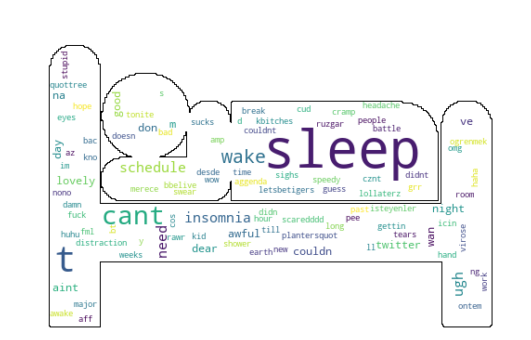

In [148]:
top_tweets_word_cloud(0,100,mask_bed)

In [162]:
topic_model.get_top_docs(topic=0, n_docs=5)

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(433521, 0.0), (160062, 0.0), (441513, 0.0), (483104, 0.0), (331367, 0.0)]

In [171]:
df.iloc([160062][2])

IndexError: list index out of range

In [168]:
def top_tweets(topic_n,n_dox):
    tuple_list = topic_model.get_top_docs(topic=topic_n, n_docs=n_dox)
    for tuple in tuple_list:
        row = tuple[0]
        print(f'Row {row}: {df.loc([row][2])}')

In [169]:
top_tweets(0,5)

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


IndexError: list index out of range

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


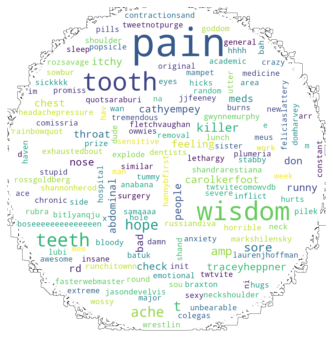

In [149]:
top_tweets_word_cloud(8,100,mask_circle)

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


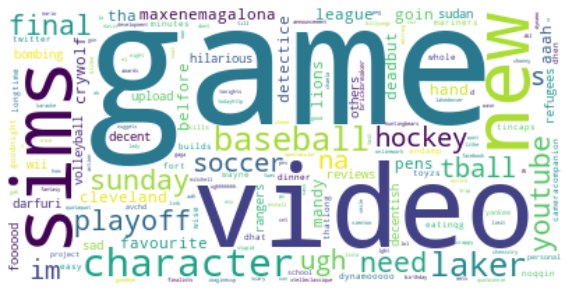

In [151]:
top_tweets_word_cloud(11,100)

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


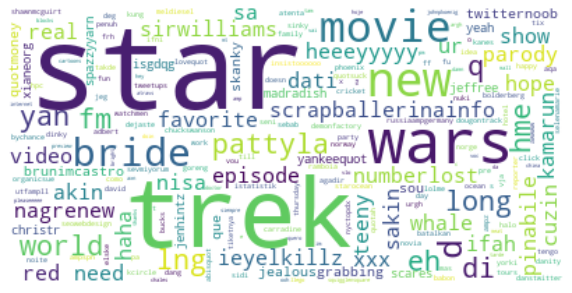

In [152]:
top_tweets_word_cloud(10,100)

In [153]:
topic_model.get_top_docs(topic=10, n_docs=5)

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(313424, 0.0), (497159, 0.0), (481926, 0.0), (219976, 0.0), (201870, 0.0)]

In [134]:
topic_categories = pd.DataFrame(topic_model.predict(data_vectorized_J), columns=['topic'+str(i) for i in range(13)])
topic_categories.head(3)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12
0,False,True,False,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False


In [135]:
import matplotlib.pyplot as plt

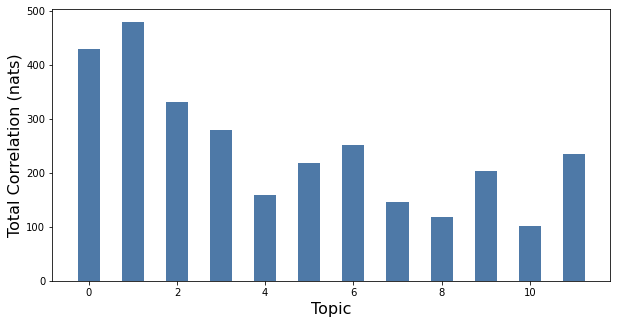

In [172]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs*1000, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

### PICKLE FOR MULTI BAR GRAPH

In [174]:
list_400K_topic_dist = list(topic_model.tcs*1000)

In [175]:
import pickle

In [176]:
with open('list_400K_topic_dist.pickle','wb') as to_write:
    pickle.dump(list_400K_topic_dist, to_write)

In [177]:
print(list_400K_topic_dist)

[429.52634791134017, 478.9849446278056, 331.16276469724, 278.2169359218091, 159.20151734366843, 217.8858101410278, 250.5344388710229, 146.57529647717254, 118.5781101018387, 203.6774813374661, 101.56031532520987, 234.72755128030352]


In [ ]:
### K-Means Clustering & Inertia